In [1]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [2]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
env_name='CartPole-v0'

In [3]:
# Training loop for OPPO
from OPPO import baseline_1, OPPO_update
from Train_policy_func import Policy, device

lr_oppo = 0.01

# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo   = gym.make(env_name)
policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
policy_oppo.load_state_dict(torch.load("pi_oppo_final.pth"))
opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr_oppo)

# ── Hyperparams for OPPO ──
n_episodes = 1200      # keep same “number of iterations” for fair comparison
max_t      = 200  # cap on steps per episode
print_every=100
gamma=0.99
# ── Run the OPPO training ──
# scores_oppo = OPPO_update(
#     policy       = policy_oppo,
#     optimizer    = opt_oppo,
#     env          = env_oppo,
#     baseline     = baseline_1,
#     n_episodes   = n_episodes,
#     max_t        = max_t,
#     gamma        = gamma,      # you can reuse your PPO γ
#     print_every  = print_every,
#     early_stop   = False
# )

# # ── Post-processing: smooth or average returns per “block” if you like
# avg_scores_oppo = [
#     np.mean(scores_oppo[i : i + print_every])
#     for i in range(0, len(scores_oppo), print_every)
# ]

c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\youss\AppData\Local\Temp\ipykernel_16188\3513758055.py:11: FutureWarning: You are using `torch.

In [11]:
lr_oppo = 0.01

# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo2   = gym.make(env_name)
policy_oppo2 = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
#policy_oppo2.load_state_dict(torch.load("pi_oppo2_final.pth"))
opt_oppo2    = torch.optim.Adam(policy_oppo2.parameters(), lr=lr_oppo)

# ── Hyperparams for OPPO ──
n_episodes = 300      # keep same “number of iterations” for fair comparison
max_t      = 200  # cap on steps per episode
print_every=100
gamma=0.99
# ── Run the OPPO training ──
scores_oppo2 = OPPO_update(
    policy       = policy_oppo2,
    optimizer    = opt_oppo2,
    env          = env_oppo2,
    baseline     = baseline_1,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = True
)

#── Post-processing: smooth or average returns per “block” if you like
avg_scores_oppo2 = [
    np.mean(scores_oppo2[i : i + print_every])
    for i in range(0, len(scores_oppo2), print_every)
]

 34%|███▍      | 103/300 [00:01<00:05, 33.93it/s]

Episode 100	Average Score: 26.80


 67%|██████▋   | 201/300 [00:11<00:09, 10.09it/s]

Episode 200	Average Score: 158.81


100%|██████████| 300/300 [00:22<00:00, 13.22it/s]

Episode 300	Average Score: 172.28


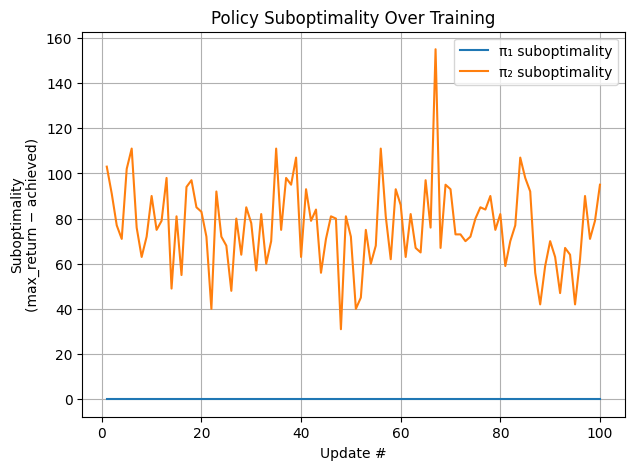

In [12]:
from PPO import ppo_update, RolloutBuffer, evaluate_policy
from Generate_traj_func import plot_suboptimality
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(policy_oppo, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(policy_oppo2, env_oppo, n_episodes=num_episodes)

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    200,
)  # in cartpole, 200 is the maximum reward

In [13]:
from pairs_generator import sample_preference_pairs
traj1 = generate_trajectory(policy_oppo, env_oppo, max_steps=1000)
traj2 = generate_trajectory(policy_oppo2, env_oppo2, max_steps=1000)

print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")

prefs = sample_preference_pairs(policy_oppo, policy_oppo2, env_oppo, K=200) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")

π₁ → length 200, total reward 200.0
π₂ → length 147, total reward 147.0
Collected 200 preference pairs.


In [16]:
from DPO import DPO_training
lr_DPO=0.1

policy_DPO=Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
policy_ref=policy_oppo
opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)
policy_DPO.load_state_dict(torch.load("pi_DPO_final.pth"))
beta=0.5

DPO_training(policy_DPO,policy_ref,prefs,beta,opt_DPO,nb_epochs=400)




C:\Users\youss\AppData\Local\Temp\ipykernel_16188\3814386155.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_DPO.load_state_dict(torch.load("pi_DPO_final.pth"))


Epoch 0: DPO Loss = 45.6120
Epoch 10: DPO Loss = 0.0000
Epoch 20: DPO Loss = 0.0000
Epoch 30: DPO Loss = 0.0000
Epoch 40: DPO Loss = 0.0000
Epoch 50: DPO Loss = 0.0000
Epoch 60: DPO Loss = 0.0000
Epoch 70: DPO Loss = 0.0000
Epoch 80: DPO Loss = 0.0000
Epoch 90: DPO Loss = 0.0000
Epoch 100: DPO Loss = 0.0000
Epoch 110: DPO Loss = 0.0000
Epoch 120: DPO Loss = 0.0000
Epoch 130: DPO Loss = 0.0000
Epoch 140: DPO Loss = 0.0000
Epoch 150: DPO Loss = 0.0000
Epoch 160: DPO Loss = 0.0000
Epoch 170: DPO Loss = 0.0000
Epoch 180: DPO Loss = 0.0000
Epoch 190: DPO Loss = 0.0000
Epoch 200: DPO Loss = 0.0000
Epoch 210: DPO Loss = 0.0000
Epoch 220: DPO Loss = 0.0000
Epoch 230: DPO Loss = 0.0000
Epoch 240: DPO Loss = 0.0000
Epoch 250: DPO Loss = 0.0000
Epoch 260: DPO Loss = 0.0000
Epoch 270: DPO Loss = 0.0000
Epoch 280: DPO Loss = 0.0000
Epoch 290: DPO Loss = 0.0000
Epoch 300: DPO Loss = 0.0000
Epoch 310: DPO Loss = 0.0000
Epoch 320: DPO Loss = 0.0000
Epoch 330: DPO Loss = 0.0000
Epoch 340: DPO Loss = 0.

π₁ → length 8, total reward 8.0


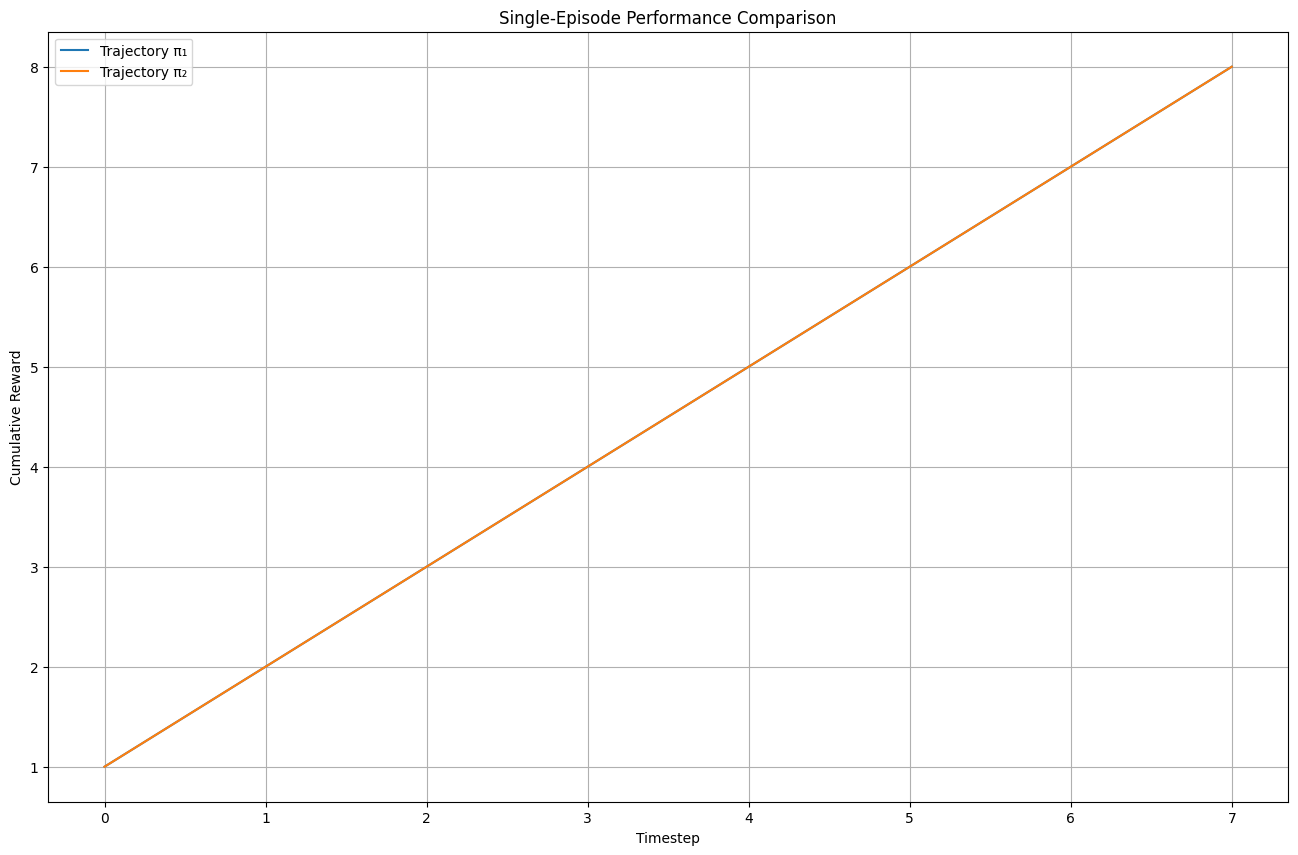

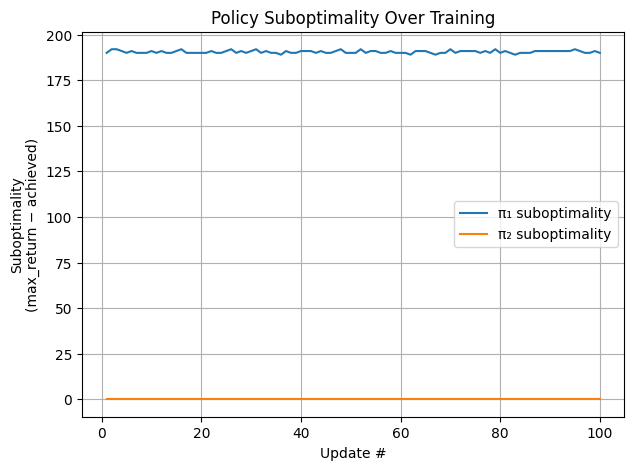

In [18]:
from Generate_traj_func import generate_trajectory,plot_trajectory_performance, plot_suboptimality
env_oppo.reset()
traj_DPO=generate_trajectory(policy_DPO,env_oppo2,max_steps=1000)
print(f"π₁ → length {len(traj_DPO)}, total reward {sum(s['reward'] for s in traj_DPO):.1f}")
plot_trajectory_performance(traj_DPO,traj_DPO)

from PPO import ppo_update, RolloutBuffer, evaluate_policy
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(policy_DPO, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(policy_ref, env_oppo, n_episodes=num_episodes)

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    200,
)  # in cartpole, 200 is the maximum reward

In [9]:
torch.save(policy_oppo.state_dict(), "pi_oppo_final.pth")
print("Saved final policy as pi_oppo_final.pth")
torch.save(policy_oppo2.state_dict(), "pi_oppo2_final.pth")
print("Saved final policy as pi_oppo2_final.pth")
torch.save(policy_DPO.state_dict(), "pi_DPO_final.pth")
print("Saved final policy as pi_DPO_final.pth")

Saved final policy as pi_oppo_final.pth
Saved final policy as pi_oppo2_final.pth
Saved final policy as pi_DPO_final.pth
